In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from scipy.signal import fftconvolve
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap

# Part 1 Template Matching NCC

In [2]:
search = imread('./data/search.png')
template = imread('./data/template.png')

In [3]:
image_shape = search.shape

image = np.array(search, dtype=np.float64, copy=False)

In [4]:
pad_width = tuple((width, width) for width in template.shape)

In [5]:
image = np.pad(image, pad_width=pad_width, mode='constant', constant_values=0)

In [6]:
def calc_window_sum(image, window_shape):
    window_sum = np.cumsum(image, axis=0)
    window_sum = (window_sum[window_shape[0]:-1] - window_sum[:-window_shape[0] - 1])
    window_sum = np.cumsum(window_sum, axis=1)
    window_sum = (window_sum[:, window_shape[1]:-1] - window_sum[:, :-window_shape[1] - 1])
    window_sum = np.cumsum(window_sum, axis=2)
    window_sum = (window_sum[:, :, window_shape[2]:-1] - window_sum[:, :, :-window_shape[2] - 1])
    return window_sum

In [7]:
image_window_sum = calc_window_sum(image, template.shape)
image_window_sum2 = calc_window_sum(image ** 2, template.shape)

In [8]:
template_mean = template.mean()
template_volume = np.prod(template.shape)
template_ssd = np.sum((template - template_mean) ** 2)

In [9]:
xcorr = fftconvolve(image, template[::-1, ::-1, ::-1], mode="valid")[1:-1, 1:-1, 1:-1]

In [10]:
numerator = xcorr - image_window_sum * template_mean

In [11]:
denominator = image_window_sum2

In [12]:
image_window_sum = np.multiply(image_window_sum, image_window_sum)

In [13]:
image_window_sum = np.divide(image_window_sum, template_volume)

In [14]:
denominator -= image_window_sum
denominator *= template_ssd

In [15]:
denominator = np.maximum(denominator, 0) # sqrt of negative number not allowed

In [16]:
denominator = np.sqrt(denominator)

In [17]:
response = np.zeros_like(xcorr, dtype=np.float64)

In [18]:
mask = denominator > np.finfo(np.float64).eps

In [19]:
response[mask] = numerator[mask] / denominator[mask]

In [20]:
slices = []

In [21]:
for i in range(template.ndim):
    d0 = template.shape[i] - 1
    d1 = d0 + image_shape[i] - template.shape[i] + 1
    slices.append(slice(d0, d1))

In [22]:
result = response[tuple(slices)]

In [23]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

In [187]:
ind_list = [1, 2, 5, 10, 100, 500]
x_list = []
y_list = []

for t in ind_list:
    ind = largest_indices(result, t)
    x_t, y_t = ind[1][-1], ind[0][-1]
    x_list.append(x_t)
    y_list.append(y_t)

In [25]:
ij = np.unravel_index(np.argmax(result), result.shape)
_, x, y = ij[::-1] # IMPORTANT TO SWITCH ROWS AND COLUMUNS I've LOST 5 points this semester because of this

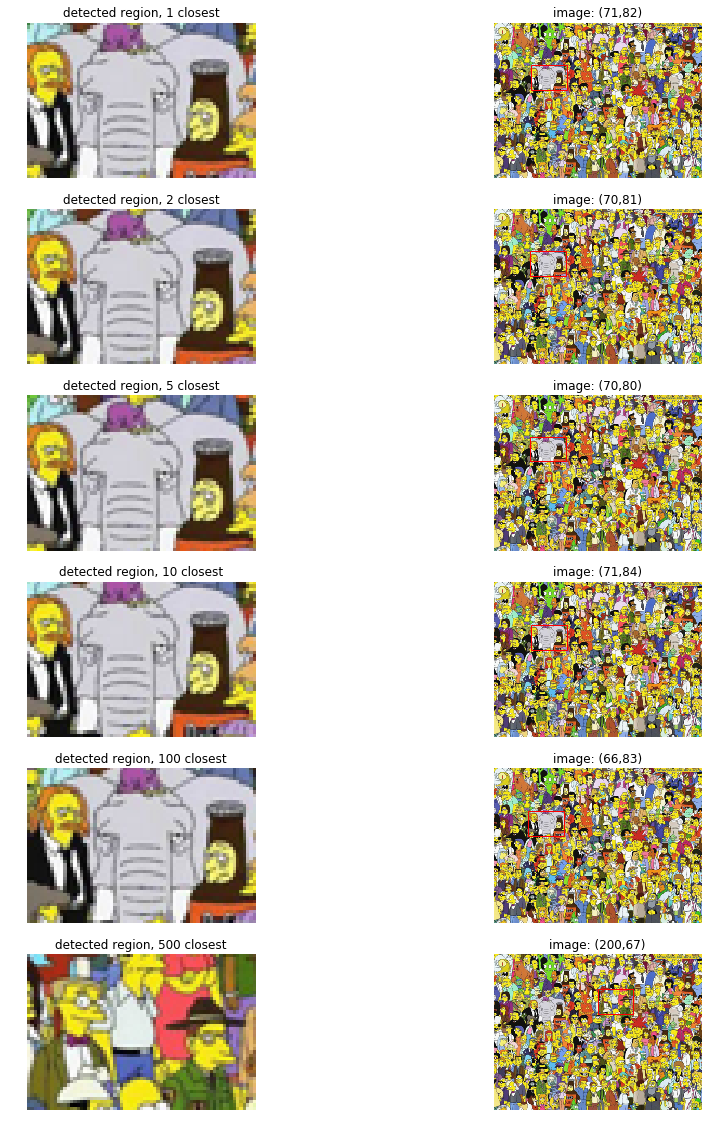

In [209]:
plot_n = 6

fig, axarr = plt.subplots(6, 2, figsize=(15,20))

for i in range(plot_n):
    htemplate, wtemplate, _ = template.shape

    axarr[i, 0].imshow(search[y_list[i]: y_list[i]+htemplate, x_list[i]:x_list[i]+wtemplate])
    axarr[i, 0].set_axis_off()
    axarr[i, 0].set_title(f'detected region, {ind_list[i]} closest')

    axarr[i, 1].imshow(search)
    axarr[i, 1].set_axis_off()
    axarr[i, 1].set_title(f'image: ({x_list[i]},{y_list[i]})')


    rect = plt.Rectangle((x_list[i], y_list[i]), wtemplate, htemplate, edgecolor='r', facecolor='none')

    axarr[i, 1].add_patch(rect)

plt.show()

We can see that our template matching performs really well in that it identifies "Stampy" the elephant pretty much pixel for pixel. Even the 2nd and 5th closest guesses are almost indistinguishable because of their 1-2 pixel discrepancy. We see however that in 100th closest our match drifts little too much to the left, as witnessed by the fact that there is more of John Swartzwelder (the guy in suit) and Brandine (the lady on the right) is now nowhere to be seen. By 500th closest, we can clearly see that the matching is way off, (its now closer to Homer rather than Stampy). This is in line with what we discussed in the slides with the person's image and the mountain behind

# Part 2 Template Matching Stereo Vision

In [27]:
left = imread('./data/left.png')
right = imread('./data/right.png')

In [233]:
w, h = left.shape

In [235]:
kernel_half = 11 // 2

In [238]:
lwindow = left[kernel_half-kernel_half:kernel_half+kernel_half, kernel_half-kernel_half:kernel_half+kernel_half]

In [239]:
lwindow

array([[25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25, 25, 25, 25, 25]], dtype=uint8)

In [240]:
def stereo_match(left_img, right_img, kernel=11, max_offset=50):
    
    w, h = left_img.shape  # assume that both images are same size   
    
    # Depth (or disparity) map
    depth = np.zeros((w, h), np.uint8)
    depth.shape = h, w
       
    kernel_half = kernel // 2 
    offset_adjust = 255 / max_offset  # this is used to map depth map output to 0-255 range
      
    for y in range(kernel_half, h - kernel_half):      
        
        for x in range(kernel_half, w - kernel_half):
            best_offset = 0
            prev_ncc = float("-inf")
            
            for offset in range(max_offset):   
                
                ncc = 0
                
                lwindow = left[y-kernel_half:y+kernel_half, x-kernel_half:x+kernel_half]
                
                lwindow_mean = lwindow.mean()
                lwindow_std = np.std(lwindow)
                
                for v in range(-kernel_half, kernel_half):
                    for u in range(-kernel_half, kernel_half):
                    # iteratively sum the sum of squared differences value for this block
                    # left[] and right[] are arrays of uint8, so converting them to int saves
                    # potential overflow, and executes a lot faster 
                        ncc_temp = (int(left[y+v, x+u]) - lwindow_mean) * (int(right[y+v, (x+u) - offset]) - lwindow_mean)
                        if lwindow_std ==0:
                            ncc_temp = 0
                        else:
                            ncc_temp /= lwindow_std*lwindow_std
                        ncc += ncc_temp 
                    
                
                            
                if ncc > prev_ncc:
                    prev_ncc = ncc
                    best_offset = offset
                            
            # set depth output for this x,y location to the best match
            depth[y, x] = best_offset * offset_adjust
                                
    # Convert to PIL and save it
    return depth

In [ ]:
plt.imshow(stereo_match(left, right), cmap='gray')

In [28]:
def calc_window_sum_2d(image, window_shape):
    window_sum = np.cumsum(image, axis=0)
    window_sum = (window_sum[window_shape[0]:-1] - window_sum[:-window_shape[0] - 1])
    window_sum = np.cumsum(window_sum, axis=1)
    window_sum = (window_sum[:, window_shape[1]:-1] - window_sum[:, :-window_shape[1] - 1])
    return window_sum

In [29]:
def matchTemplate(image, template):
    pad_width = tuple((width, width) for width in template.shape)
    image = np.pad(image, pad_width=pad_width, mode='constant', constant_values=0)
    image_window_sum = calc_window_sum_2d(image, template.shape)
    image_window_sum2 = calc_window_sum_2d(image ** 2, template.shape)
    template_mean = template.mean()
    template_volume = np.prod(template.shape)
    template_ssd = np.sum((template - template_mean) ** 2)
    xcorr = fftconvolve(image, template[::-1, ::-1], mode="valid")[1:-1, 1:-1]
    numerator = xcorr - image_window_sum * template_mean
    denominator = image_window_sum2
    image_window_sum = np.multiply(image_window_sum, image_window_sum)
    image_window_sum = np.divide(image_window_sum, template_volume)
    denominator -= image_window_sum
    denominator *= template_ssd
    denominator = np.maximum(denominator, 0) # sqrt of negative number not allowed
    denominator = np.sqrt(denominator)
    response = np.zeros_like(xcorr, dtype=np.float64)
    mask = denominator > np.finfo(np.float64).eps
    response[mask] = numerator[mask] / denominator[mask]
    slices = []
    for i in range(template.ndim):
        d0 = template.shape[i] - 1
        d1 = d0 + image_shape[i] - template.shape[i] + 1
        slices.append(slice(d0, d1))
    result = response[tuple(slices)]
    return result

In [30]:
def disparity_ncorr(L, R, block_size=5, disparity_range=30, lambda_factor=0):
    im_rows, im_cols = L.shape
    tpl_rows = tpl_cols = block_size
    D_L = np.zeros(L.shape, dtype=np.float32)

    for r in range(tpl_rows//2, im_rows-tpl_rows//2):
        tr_min, tr_max = max(r-tpl_rows//2, 0), min(r+tpl_rows//2+1, im_rows)
        for c in range(tpl_cols//2, im_cols-tpl_cols//2):
            # get template
            tc_min = max(c-tpl_cols//2, 0)
            tc_max = min(c+tpl_cols//2+1, im_cols)
            tpl = L[tr_min:tr_max, tc_min:tc_max].astype(np.float32)
            # get R strip in a window with width=disparity_range
            rc_min = max(c-disparity_range//2, 0)
            rc_max = min(c+disparity_range//2+1, im_cols)
            R_strip = R[tr_min:tr_max, rc_min:rc_max].astype(np.float32)
            # find best match of template in strip
            error = matchTemplate(R_strip, tpl)
            #c_tf = max(c-rc_min-tpl_cols//2, 0)
            #dist = np.arange(error.shape[1]) - c_tf
            #cost = error - np.abs(dist * lambda_factor)
            ij = np.unravel_index(np.argmax(error), error.shape)
            x, y = ij[::-1] 
            D_L[r, c] = error[x, y]
    return D_L

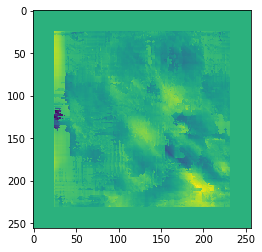

In [31]:
plt.imshow(disparity_ncorr(left, right, block_size=50, disparity_range=50))

# Part 3 k-Nearest-Neighbours

In [32]:
train = np.loadtxt('./data/train.txt')
test = np.loadtxt('./data/test.txt')
X_train, y_train = train[:,0:2], train[:,2]
X_test, y_test = test[:,0:2], test[:,2]

In [146]:
neighbours = [1, 5, 11, 15]

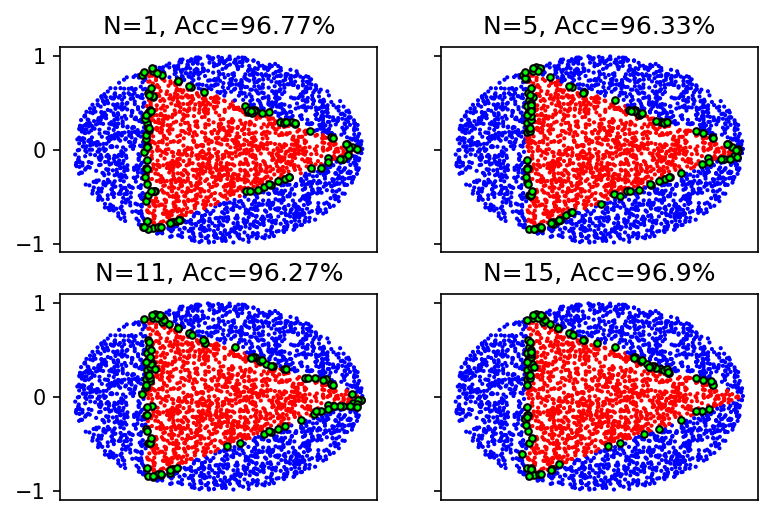

In [164]:
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', dpi=150)
for n in neighbours:
    idx = neighbours.index(n)
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    axarr[idx//2,idx%2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    axarr[idx//2,idx%2].scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=cmap_bold, s=1)
    axarr[idx//2,idx%2].scatter(X_test[y_pred!=y_test, 0], X_test[y_pred!=y_test, 1], c='#00FF00', edgecolor='k', cmap=cmap_bold, s=10)
    axarr[idx//2,idx%2].set_title(f"$k$={n}, Acc={round(model.score(X_test, y_test)*100, 2)}%")
plt.show()

We notice that most of the errors made in classification, it is at the border of our classes, this is expected as that is where the nearest neighbours will be the most contested. However as we increase our $k$, at first we notice that our accuracy decreases, as in this case there might be cases where more neighbours cause the classifier to be misled. But once we reach $k$=15, we see that our accuracy jumps up, thus indicating that at this stage we are getting sufficient enough information from our neighbours that its indicative of our overall sample.